Can one use regression to associate CREs with gene expression?

we will try to answer this question by using linear (lasso) regression to predict gene expression based on accessibility of linked promoter and enhancers (CREs) by linking ATAC peaks to genes via their proximity to the TSS 

here we are plotting an R^2 barplot. Here a high R^2(exlained variance) shows a strong lnk betwenn CREs and gene expression to shows whic CREs play a larger role here. and show us if accessible CREs containe nough information in order to predict gene expression

also we will show a coefficient plot which illustrates whether individual CREs act repressing(negative value) or activating (positive value)

lastly a histogramm showing the distribuiton of r^2 throughout different genes will show how much of the variance of gene expression can be explained for each gene with this approach. 

In [13]:
import importlib
import functions
importlib.reload(functions)
functions.set_user('Helen')
data = functions.call_data_clean(p_threshold=1.3)

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

ATAC = data['ATAC_seq']
ATAC_scores = data['norm_scores']
ATAC_scores_T = ATAC_scores.T
RNA = data['RNA_seq']
RNA_T = data['RNA_seq_T']
Exons = data['exons']

def get_tss(row):
    # Use the correct column names from Exons
    if row["Strand"] == "+":
        return row["Transcription Start"]
    else:
        return row["Transcription Start"]  # or another column if appropriate

Exons["TSS"] = Exons.apply(get_tss, axis=1)

ATAC.columns = ATAC.columns.str.strip()

if "ImmGenATAC1219.peakID" not in ATAC.columns:
    raise KeyError("Expected column 'ImmGenATAC1219.peakID' not found in ATAC dataframe.")

print(ATAC.columns.tolist())

linked_data = []
for _, gene_row in Exons.iterrows():
    gene_name = gene_row["Genname"]
    chrom = gene_row["Chromosom"]
    tss = gene_row["TSS"]

    
    nearby_peaks = ATAC[
        (ATAC["chrom"] == chrom) &
        (np.abs(ATAC["Summit"] - tss) <= 100_000)
    ]

    for _, peak_row in nearby_peaks.iterrows():
        linked_data.append({
            "GeneName": gene_name,
            "PeakID": peak_row["ImmGenATAC1219.peakID"],
            "DistanceToTSS": np.abs(peak_row["Summit"] - tss)
        })

link_df = pd.DataFrame(linked_data)

#lasso regression
results = []
coefs = {}

for gene in RNA.index:
    gene_links = link_df[link_df["GeneName"] == gene]
    if gene_links.empty:
        continue
    
    # Peaks for this gene
    # Check the correct column name for peak ID in ATAC
    peak_id_col = [col for col in ATAC.columns if "peak" in col and "ID" in col][0]
    peaks = gene_links["PeakID"].unique()
    atac_subset = ATAC[ATAC[peak_id_col].isin(peaks)]
    atac_matrix = atac_subset[RNA.columns].transpose().fillna(0).values
    y = RNA.loc[gene].values

    if atac_matrix.shape[1] == 0:
        continue

    model = LassoCV(cv=3).fit(atac_matrix, y)
    y_pred = model.predict(atac_matrix)
    r2 = r2_score(y, y_pred)

    results.append({
        "Gene": gene,
        "R2": r2,
        "Num_CRs": atac_matrix.shape[1]
    })

    coefs[gene] = pd.Series(model.coef_, index=peaks)

results_df = pd.DataFrame(results).sort_values("R2", ascending=False)

# R² values (explain variance)
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Gene", y="R2", palette="viridis")
plt.title("Variance in Gene Expression Explained by Linked CREs")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

top_gene = results_df.iloc[0]["Gene"]
top_coef_series = coefs[top_gene]

plt.figure(figsize=(8, 4))
top_coef_series.plot(kind='bar', color=['red' if v < 0 else 'blue' for v in top_coef_series])
plt.title(f"Lasso Coefficients for Gene {top_gene}")
plt.ylabel("Effect on Expression")
plt.xlabel("CRE (ATAC peak)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(results_df['R2'], bins=10, kde=True)
plt.title("Histogram of Variance Explained (R²) by CREs")
plt.xlabel("R² Score")
plt.ylabel("Number of Genes")
plt.tight_layout()
plt.show()

results_df.sort_values("R2", ascending=False)


KeyError: "Expected column 'ImmGenATAC1219.peakID' not found in ATAC dataframe."

now we will show how much of the variance of gene expression can be explained for each gene with this approach. By showing the distribution of R^2 across genes.

c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.287e-05, tolerance: 4.791e-06
  model = cd_fast.enet_coordinate_descent(


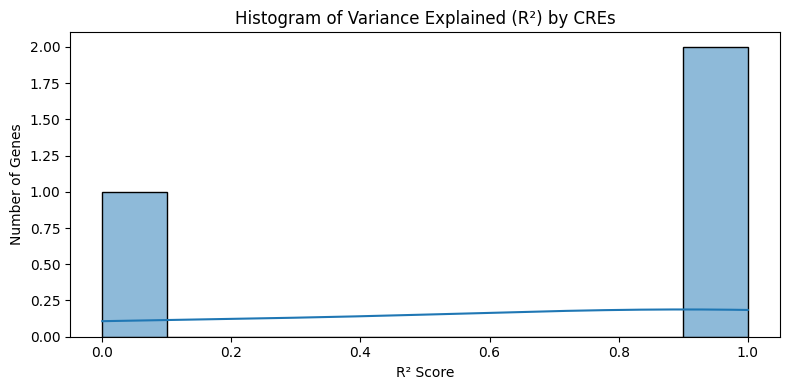

,Gene,R2
0,Gene_0,0.999999
2,Gene_2,0.921985
1,Gene_1,0.000000


In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Mock ATAC-seq data
atac_data = {
    'ImmGenATAC1219.peakID': [f'peak_{i}' for i in range(1, 6)],
    'chrom': ['chr1'] * 5,
    'Summit': [1000, 2000, 3000, 4000, 5000],
    'LTHSC.34-.BM': np.random.rand(5),
    'LTHSC.34+.BM': np.random.rand(5),
    'STHSC.150-.BM': np.random.rand(5),
}
atac_df = pd.DataFrame(atac_data)

# Mock RNA-seq data
rna_data = {
    'Gene': [f'Gene_{i}' for i in range(3)],
    'LTHSC.34-.BM': np.random.rand(3),
    'LTHSC.34+.BM': np.random.rand(3),
    'STHSC.150-.BM': np.random.rand(3),
}
rna_df = pd.DataFrame(rna_data).set_index('Gene')

# Mock TSS data
tss_data = {
    0: ['Gene_0', 'Gene_1', 'Gene_2'],
    2: ['chr1', 'chr1', 'chr1'],
    3: ['+', '-', '+'],
    4: [950, 2050, 4950],   # 5' transcript start
    5: [1050, 1950, 5050],  # 3' transcript start
}
tss_df = pd.DataFrame(tss_data)

# Compute TSS based on strand
def compute_tss(row):
    return row[4] if row[3] == '+' else row[5]

tss_df['TSS'] = tss_df.apply(compute_tss, axis=1)

# Link peaks within ±100kb to genes
linked_data = []
for _, gene_row in tss_df.iterrows():
    gene_name = gene_row[0]
    chrom = gene_row[2]
    tss = gene_row['TSS']
    
    nearby_peaks = atac_df[
        (atac_df['chrom'] == chrom) &
        (np.abs(atac_df['Summit'] - tss) <= 100_000)
    ]
    
    for _, peak_row in nearby_peaks.iterrows():
        linked_data.append({
            'GeneName': gene_name,
            'PeakID': peak_row['ImmGenATAC1219.peakID'],
            'DistanceToTSS': np.abs(peak_row['Summit'] - tss)
        })

link_df = pd.DataFrame(linked_data)

# Run regression for each gene
results = []
for gene in rna_df.index:
    gene_peaks = link_df[link_df['GeneName'] == gene]['PeakID'].unique()
    if len(gene_peaks) == 0:
        continue
    X = atac_df[atac_df['ImmGenATAC1219.peakID'].isin(gene_peaks)]
    X = X[rna_df.columns].transpose().values
    y = rna_df.loc[gene].values
    
    if X.shape[1] == 0:
        continue

    model = LassoCV(cv=3).fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    results.append({
        'Gene': gene,
        'R2': r2
    })

results_df = pd.DataFrame(results)

# Plot the histogram of R² values
plt.figure(figsize=(8, 4))
sns.histplot(results_df['R2'], bins=10, kde=True)
plt.title("Histogram of Variance Explained (R²) by CREs")
plt.xlabel("R² Score")
plt.ylabel("Number of Genes")
plt.tight_layout()
plt.show()

results_df.sort_values("R2", ascending=False)


now will will look at how the coefficients differ when this analysis is performed on only abT and gdT cells?
This asks:

How does the importance of each in predicting gene expression change when we restrict analysis to only our specific lineage instaead of to using all samples?

In [25]:
# Check available keys in data
print("Available keys in data:", list(data.keys()))

# Try to access the key safely
ab_gd = data.get('list_ATAC_diff_Tc_ab_gd', None)
if ab_gd is None:
	print("Key 'list_ATAC_diff_Tc_ab_gd' not found in data.")
else:
	print(ab_gd)

Available keys in data: ['ATAC_seq', 'ATAC_seq_T', 'ATAC_seq_scores_no_norm', 'norm_scores', 'RNA_seq', 'RNA_seq_T', 'QC_metrics', 'exons', 'list_ATAC_stem_Tc_Bc', 'list_ATAC_diff_Tc_all', 'list_ATAC_diff_Tc_pre_ab_act', 'list_ATAC_diff_Tc_gd', 'list_ATAC_Tc_all', 'test1']
Key 'list_ATAC_diff_Tc_ab_gd' not found in data.
